In [125]:
import boto3
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
session = boto3.session.Session()

In [3]:
logs_client = session.client('logs')

In [13]:
log_group_names = [group['logGroupName'] for group in logs_client.describe_log_groups(logGroupNamePrefix='/aws/lambda/perf_')['logGroups']]
log_group_names

['/aws/lambda/perf_image_Python310',
 '/aws/lambda/perf_image_Python311',
 '/aws/lambda/perf_image_Python38',
 '/aws/lambda/perf_image_Python39',
 '/aws/lambda/perf_zip_Python310',
 '/aws/lambda/perf_zip_Python311',
 '/aws/lambda/perf_zip_Python38',
 '/aws/lambda/perf_zip_Python39',
 '/aws/lambda/perf_zip_layers_Python310',
 '/aws/lambda/perf_zip_layers_Python311',
 '/aws/lambda/perf_zip_layers_Python38',
 '/aws/lambda/perf_zip_layers_Python39']

In [175]:
end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(hours=7)

In [176]:
quer = logs_client.start_query(
    logGroupNames=log_group_names,
    startTime=int(start_time.timestamp()),
    endTime=int(end_time.timestamp()),
    queryString="""
filter @type = "REPORT"
| filter ispresent(@initDuration)
| parse @log '/aws/lambda/*' as function_name
| filter function_name like 'Python39'
| parse function_name '_*_Py' as pkg_method
| display @timestamp, pkg_method, function_name, @initDuration
| sort @timestamp asc
| limit 10000
""")

In [177]:
res = logs_client.get_query_results(queryId=quer['queryId'])
while res['status'] not in ('Complete'):
    if res['status'] in ('Failed', 'Cancelled', 'Timeout'):
        print('Query is in status', res['status'])
        break
    res = logs_client.get_query_results(queryId=quer['queryId'])

In [178]:
len(res['results'])

1786

In [179]:
data = []
timestamp, pkg_method, function_name, init_duration = None, None, None, None
for (idx, result) in enumerate(res['results']):
    for field in result:
        if field['field'] == '@timestamp':
            timestamp = field['value']
        elif field['field'] == 'pkg_method':
            pkg_method = field['value']
        elif field['field'] == 'function_name':
            function_name = field['value']
        elif field['field'] == '@initDuration':
            init_duration = float(field['value'])
    if timestamp is not None and function_name is not None and pkg_method is not None and init_duration is not None:
        data.append([timestamp, function_name, pkg_method, init_duration])

In [180]:
df = pd.DataFrame(data, columns=['Timestamp', 'FunctionName', 'PackageMethod', 'InitDuration'])
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [181]:
df

,Timestamp,FunctionName,PackageMethod,InitDuration
0,2023-11-13 12:16:16.021,perf_image_Python39,image,1827.98
1,2023-11-13 12:16:17.970,perf_zip_Python39,zip,3350.24
2,2023-11-13 12:16:18.024,perf_zip_layers_Python39,zip_layers,3177.73
3,2023-11-13 12:22:04.324,perf_image_Python39,image,1323.32
4,2023-11-13 12:22:05.920,perf_image_Python39,image,1231.33
...,...,...,...,...
1781,2023-11-13 18:57:14.890,perf_zip_layers_Python39,zip_layers,3117.36
1782,2023-11-13 18:57:14.909,perf_zip_layers_Python39,zip_layers,3056.79
1783,2023-11-13 18:57:14.911,perf_zip_layers_Python39,zip_layers,3081.85
1784,2023-11-13 18:57:14.984,perf_zip_Python39,zip,3231.90


In [182]:
df.size

7144

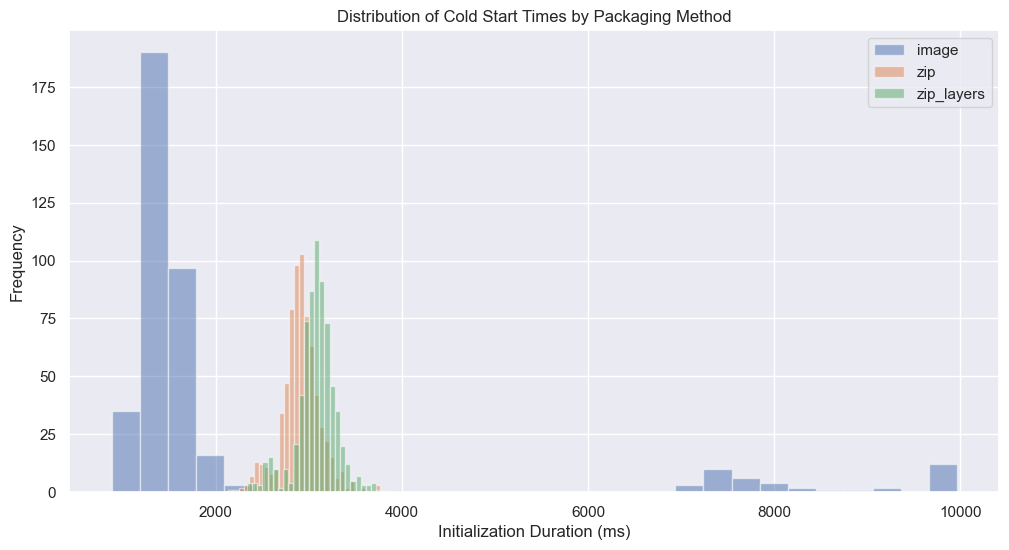

In [197]:
plt.figure(figsize=(12, 6))
for method in df['PackageMethod'].unique():
    subset = df[df['PackageMethod'] == method]
    plt.hist(subset['InitDuration'], bins=30, alpha=0.5, label=method)

plt.title('Distribution of Cold Start Times by Packaging Method')
plt.xlabel('Initialization Duration (ms)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('distribution.png', pad_inches=0.3, bbox_inches='tight')
plt.show()

In [184]:
df['TimeDiff'] = df['Timestamp'].diff()
threshold = pd.Timedelta(minutes=1)
df['NewRange'] = df['TimeDiff'] > threshold
df['RangeGroup'] = df['NewRange'].cumsum()
df_contiguous_ranges = df.groupby('RangeGroup')['Timestamp'].agg(['min', 'max'])

contiguous_ranges = df_contiguous_ranges.to_records(index=False)
contiguous_ranges

rec.array([('2023-11-13T12:16:16.021000000', '2023-11-13T12:16:18.024000000'),
           ('2023-11-13T12:22:04.324000000', '2023-11-13T12:22:08.988000000'),
           ('2023-11-13T12:27:48.424000000', '2023-11-13T12:27:48.424000000'),
           ('2023-11-13T12:30:55.407000000', '2023-11-13T12:31:37.223000000'),
           ('2023-11-13T12:37:29.668000000', '2023-11-13T12:37:31.246000000'),
           ('2023-11-13T13:49:49.728000000', '2023-11-13T13:49:54.372000000'),
           ('2023-11-13T14:16:51.188000000', '2023-11-13T14:16:59.887000000'),
           ('2023-11-13T14:20:59.613000000', '2023-11-13T14:21:04.805000000'),
           ('2023-11-13T15:56:11.621000000', '2023-11-13T15:56:17.779000000'),
           ('2023-11-13T17:39:52.379000000', '2023-11-13T17:39:57.787000000'),
           ('2023-11-13T18:57:09.328000000', '2023-11-13T18:57:15.031000000')],
          dtype=[('min', '<M8[ns]'), ('max', '<M8[ns]')])

2023-11-13T12:16:16.021000000 2023-11-13T12:16:18.024000000 0 7 0


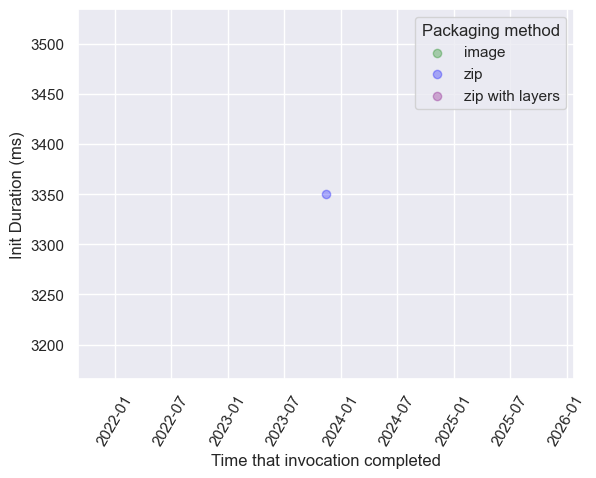

2023-11-13T12:22:04.324000000 2023-11-13T12:22:08.988000000 14 14 70


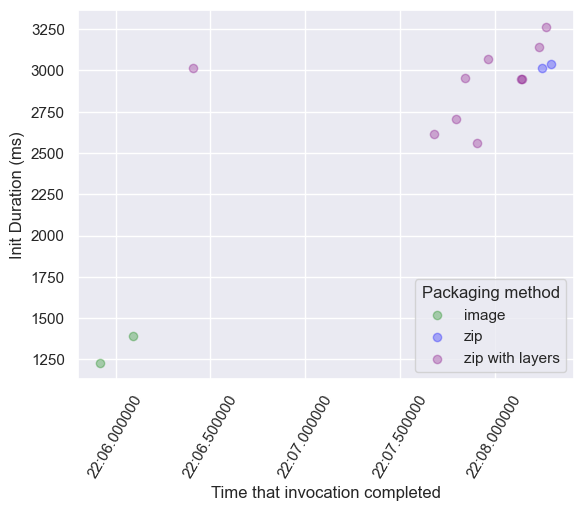

2023-11-13T12:27:48.424000000 2023-11-13T12:27:48.424000000 0 0 0


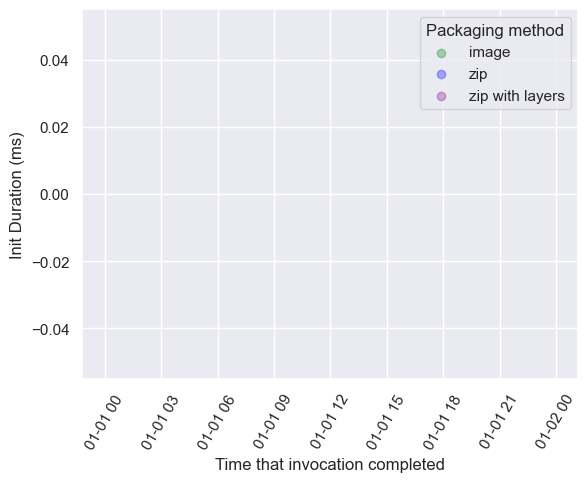

2023-11-13T12:30:55.407000000 2023-11-13T12:31:37.223000000 42 42 0


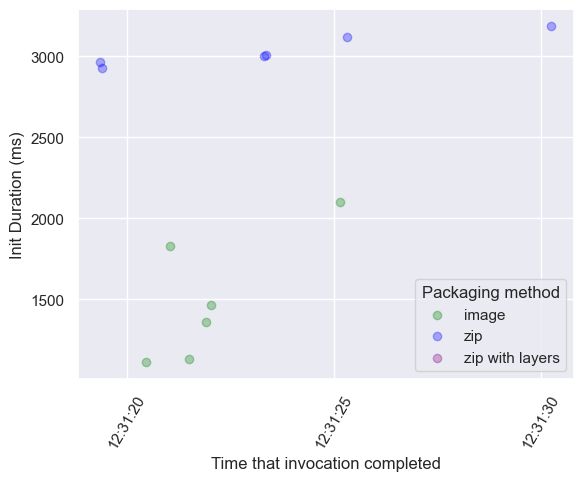

2023-11-13T12:37:29.668000000 2023-11-13T12:37:31.246000000 0 14 28


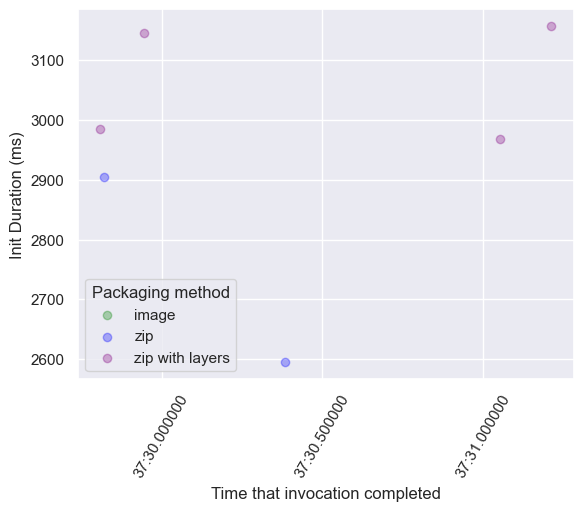

2023-11-13T13:49:49.728000000 2023-11-13T13:49:54.372000000 448 700 693


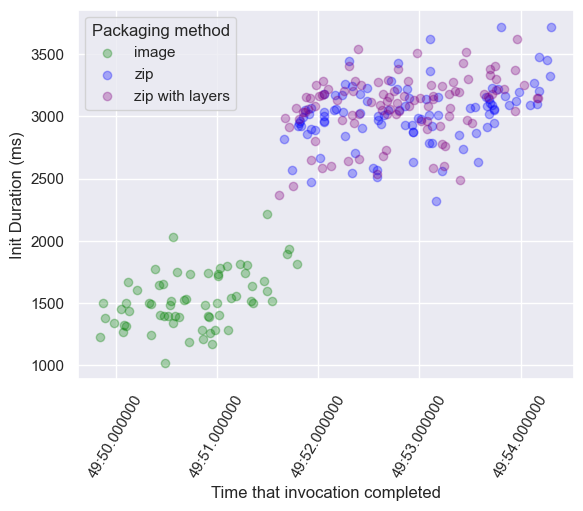

2023-11-13T14:16:51.188000000 2023-11-13T14:16:59.887000000 280 609 567


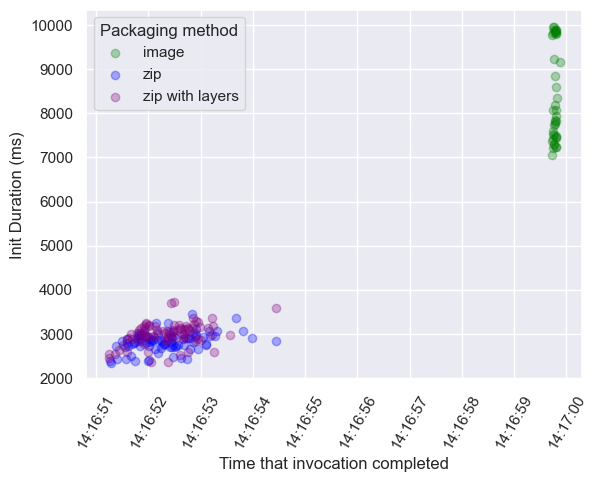

2023-11-13T14:20:59.613000000 2023-11-13T14:21:04.805000000 371 693 686


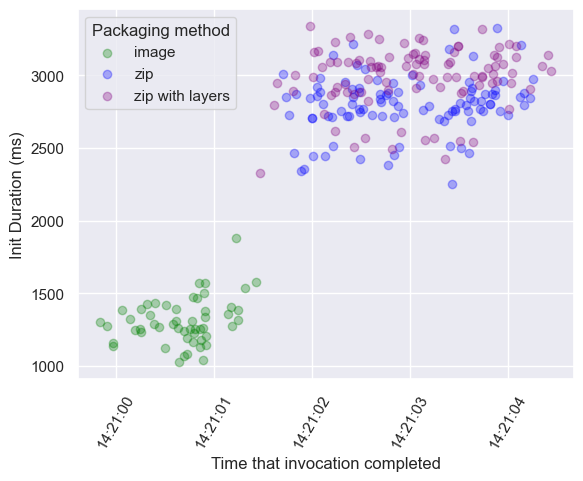

2023-11-13T15:56:11.621000000 2023-11-13T15:56:17.779000000 441 924 980


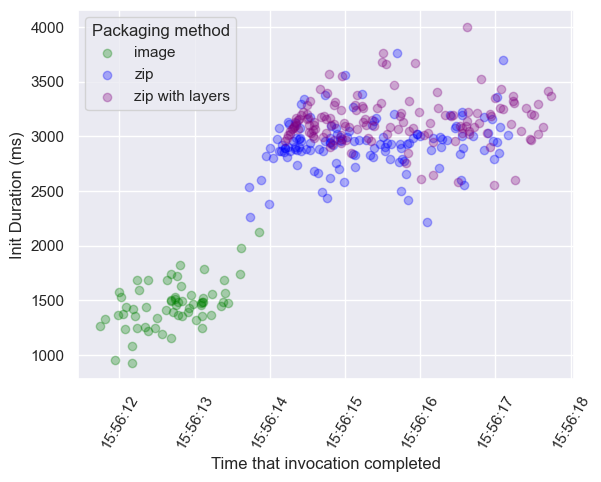

2023-11-13T17:39:52.379000000 2023-11-13T17:39:57.787000000 560 959 896


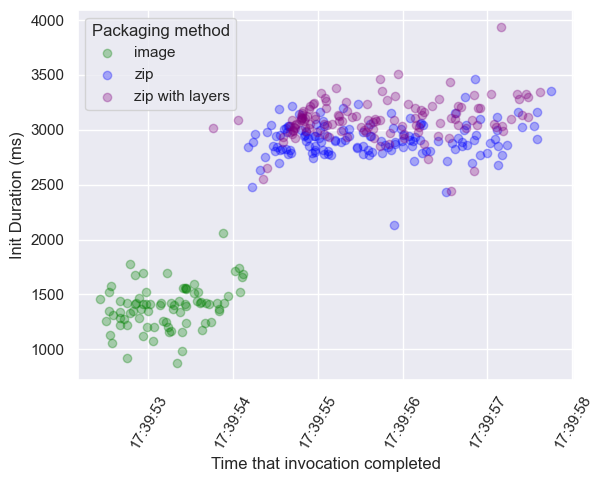

2023-11-13T18:57:09.328000000 2023-11-13T18:57:15.031000000 455 952 910


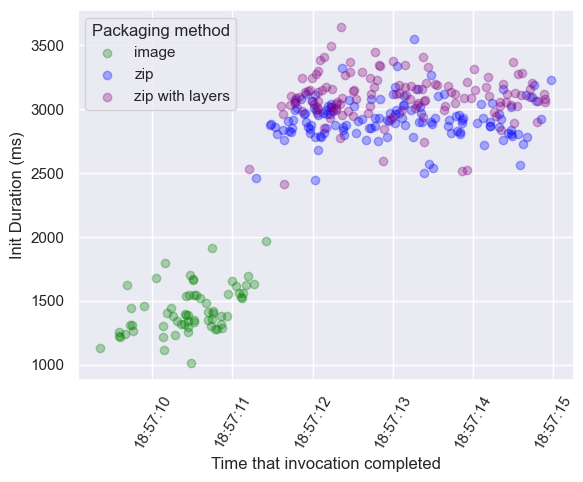

In [196]:
for idx, (start_date, end_date) in enumerate(contiguous_ranges):
    range_df = df[(df['Timestamp'] < end_date) & (df['Timestamp'] > start_date)]
    df_image = range_df[range_df['PackageMethod']=='image']
    df_zip = range_df[range_df['PackageMethod']=='zip']
    df_zip_layers= range_df[range_df['PackageMethod']=='zip_layers']
    print(start_date, end_date, df_image.size, df_zip.size, df_zip_layers.size)
    
    plt.scatter(df_image['Timestamp'], df_image['InitDuration'], c='green', alpha=0.3, label='image')
    plt.scatter(df_zip['Timestamp'], df_zip['InitDuration'], c='blue', alpha=0.3, label='zip')
    plt.scatter(df_zip_layers['Timestamp'], df_zip_layers['InitDuration'], c='purple', alpha=0.3, label='zip with layers')
    plt.xlabel('Time that invocation completed')
    plt.xticks(rotation=60)
    plt.ylabel('Init Duration (ms)')
    plt.legend(title='Packaging method')
    plt.savefig(f"{idx}.png", pad_inches=0.3, bbox_inches='tight')
    plt.show()